In [1]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err
from gofish import imagecube  
from scipy.interpolate import griddata

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [2]:
target = 'AA_Tau'

robust = -0.5

In [3]:
mask_threshold = 5

target_label = disk.disk[target]['label']
rout = disk.disk[target]['rout']
distance_pc = disk.disk[target]['distance']

# load data
dhdu = fits.open(f'../frank_fit/CLEAN/robust{robust}/{target}_data_robust{robust}.fits')
dimg, hd = np.squeeze(dhdu[0].data), dhdu[0].header

# load frank model
fhdu = fits.open(f'../frank_fit/CLEAN/robust{robust}/{target}_model_robust{robust}.fits')
fimg, fhd = np.squeeze(fhdu[0].data), fhdu[0].header

# load frank residuals
reshdu = fits.open(f'../frank_fit/CLEAN/robust{robust}/{target}_resid_robust{robust}.fits')
resimg, reshd = np.squeeze(reshdu[0].data), dhdu[0].header

RMS_data = np.loadtxt(f'../frank_fit/CLEAN/robust{robust}/Info_image_data_{target}_robust{robust}.txt')[5]

# mask from data image
mask = dimg*1e3>mask_threshold*RMS_data
converted_mask = np.where(mask, 1, np.nan)

residuals_mask = resimg[mask]
model_mask = fimg[mask]
data_mask = dimg[mask]
NAI =  np.sum(np.abs(residuals_mask)) / np.sum(np.abs(model_mask))

print(f'NAI of {target}: {NAI:.3f}')

NAI of AA_Tau: 0.120


# Plots

In [5]:
img_lim = 1.2     # multiple of rout, used to set the limit of the images and the intesity radial profile
res_vmin, res_vmax = -5, 5    # min and max values in the residual image
maj_ticks = 0.5          # arcsec, spacing of the major ticks in figures
min_ticks = maj_ticks/5  # arcsec, spacing of the minor ticks in figures

# parse coordinate frame indices into physical numbers
RA = 3600 * hd['CDELT1'] * (np.arange(hd['NAXIS1']) - (hd['CRPIX1'] - 1)) 
DEC = 3600 * hd['CDELT2'] * (np.arange(hd['NAXIS2']) - (hd['CRPIX2'] - 1))
dRA, dDEC = np.meshgrid(RA - disk.disk[target]['dx'], 
                        DEC - disk.disk[target]['dy'])
freq = hd['CRVAL3']

# image setups
rout = disk.disk[target]['rout']
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# beam parameters
bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

# image setups
rout = disk.disk[target]['rout']
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())
#im_bounds_au = np.asarray(im_bounds)*distance_pc
dRA_lims, dDEC_lims = [img_lim*rout, -img_lim*rout], [-img_lim*rout, img_lim*rout]
#dRA_lims_au = np.asarray(dRA_lims)*distance_pc
#dDEC_lims_au = np.asarray(dDEC_lims)*distance_pc

# residuals color map
c2 = plt.cm.Reds(np.linspace(0, 1, 32))
c1 = plt.cm.Blues_r(np.linspace(0, 1, 32))
c1 = np.vstack([c1, np.ones((10, 4))])
colors = np.vstack((c1, c2))
mymap = mcolors.LinearSegmentedColormap.from_list('eddymap', colors)

separations = 20   # discrete colorbar
discrete_colors = plt.get_cmap(mymap)(np.linspace(0,1,separations))
discrete_cmap = mcolors.ListedColormap(discrete_colors) 

# beam parameters
bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

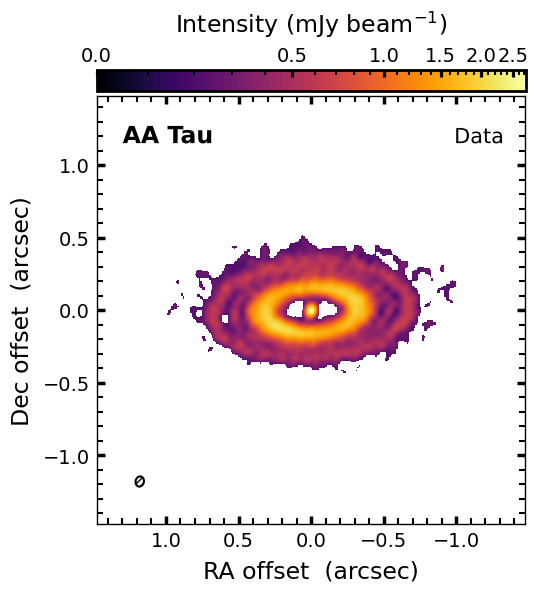

In [6]:
##########################
### Plot the data image
##########################

fig = plt.figure(figsize=(7.0, 5.9))
ax = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
cmap = 'inferno'
im = ax.imshow(dimg*converted_mask*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar = fig.colorbar(im, ax=ax, pad=0.01, location='top', fraction=0.0472)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=10, fontsize = 17)
#cbar.set_ticks([0,0.5,1])
cbar.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax.add_artist(beam)

# Write source name
ax.text(0.06, 0.89, s=target_label,
        transform=ax.transAxes, color='k', fontsize=17, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

ax.text(0.95, 0.89, "Data",
        transform=ax.transAxes, color='k', fontsize=15, ha='right',
        path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)

# axes style
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))
ax.yaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(min_ticks)) 
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)

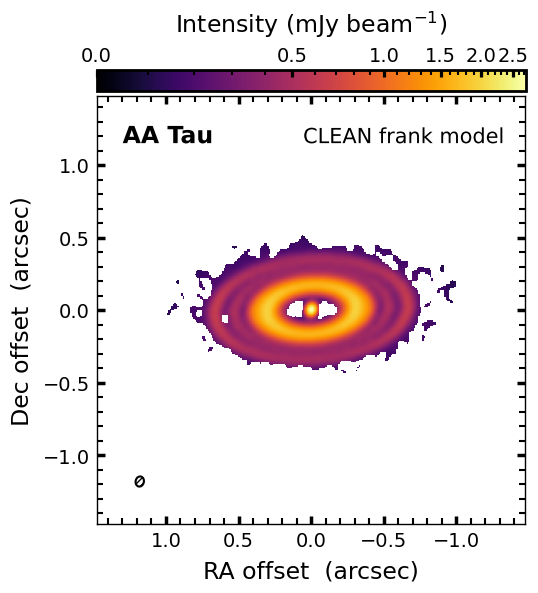

In [7]:
##########################
### Plot the model image
##########################

fig = plt.figure(figsize=(7.0, 5.9))
ax = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=0, vmax=np.nan_to_num(dimg).max()*1e3, stretch=AsinhStretch())
cmap = 'inferno'
im = ax.imshow(fimg*converted_mask*1e3, origin='lower', cmap=cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar = fig.colorbar(im, ax=ax, pad=0.01, location='top', fraction=0.0472)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar.set_label('Intensity (mJy $\mathrm{beam}^{-1}$)', labelpad=10, fontsize = 17)
#cbar.set_ticks([0,0.5,1])
cbar.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax.add_artist(beam)

# Write source name
ax.text(0.06, 0.89, s=target_label,
        transform=ax.transAxes, color='k', fontsize=17, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

ax.text(0.95, 0.89, "CLEAN frank model",
        transform=ax.transAxes, color='k', fontsize=15, ha='right',
        path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)

# axes style
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))
ax.yaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(min_ticks)) 
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)

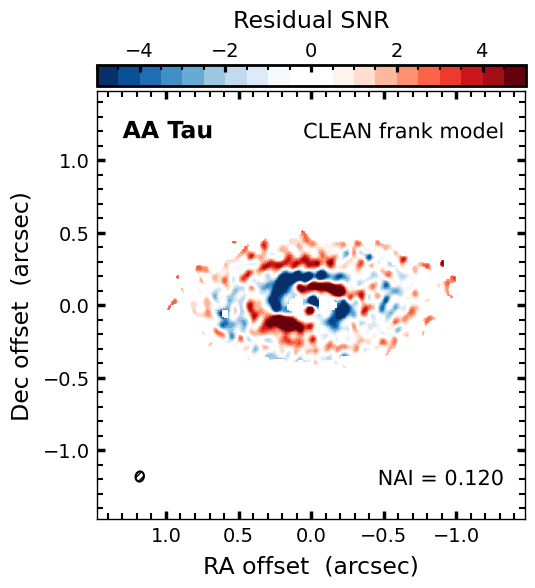

In [8]:
##########################
### Plot the residual image
##########################

fig = plt.figure(figsize=(7.0, 5.9))
ax = fig.add_subplot(111)

# intensity limits, and stretch
norm = ImageNormalize(vmin=res_vmin, vmax=res_vmax, stretch=LinearStretch())
cmap = 'inferno'
im = ax.imshow(resimg*1e3/RMS_data*converted_mask, origin='lower', cmap=discrete_cmap, extent=im_bounds, norm=norm)

# add scalebars
cbar = fig.colorbar(im, ax=ax, pad=0.01, location='top', fraction=0.0472)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar.set_label('Residual SNR', labelpad=10, fontsize = 17)
#cbar.set_ticks([0,0.5,1])
cbar.ax.minorticks_on()

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), 
                dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax.add_artist(beam)

# Write source name
ax.text(0.06, 0.89, s=target_label,
        transform=ax.transAxes, color='k', fontsize=17, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

ax.text(0.95, 0.89, "CLEAN frank model",
        transform=ax.transAxes, color='k', fontsize=15, ha='right',
        path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

ax.text(0.95, 0.08, s=f'NAI = {NAI:.3f}',
        transform=ax.transAxes, color='k', fontsize=15, ha='right',
        path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)

# axes style
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))
ax.yaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(min_ticks)) 
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)